In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings

In [2]:
warnings.filterwarnings('ignore')  # Ignores all warnings
# Load the data
data_path = 'cirrhosis_clean.csv'
data = pd.read_csv(data_path)
# Display the first few rows of the dataframe to understand its structure
data.head()

,ID,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema
0,1,-1.432360,0.827904,2.485914,-0.491215,-2.194559,0.684867,-0.123847,0.271931,0.764998,-0.757816,1.470371,1.104369,0,0,0,0,0,0,0
1,2,2.223526,0.608395,-0.476689,-0.305613,1.478942,-0.512297,2.532642,-0.159629,-0.593622,-0.430953,-0.125301,-0.036569,1,0,0,1,0,0,1
2,3,-0.886652,1.898239,-0.410362,-0.876001,-0.095416,1.318660,-0.686329,-0.467356,-1.127366,-1.169029,1.270912,1.104369,0,0,1,1,1,1,2
3,4,-0.072549,0.446938,-0.321927,-0.568172,-2.337683,-0.394928,1.936935,-1.093939,-0.528926,-0.831623,-0.424490,1.104369,0,0,0,1,0,0,2
4,5,-0.447946,-1.127724,0.031817,-0.409731,0.023854,0.532288,-0.613796,-0.166165,-0.852407,-1.327189,0.173887,-0.036569,2,1,0,1,0,0,1


In [3]:
# Separate the features and the target variable
X = data.drop(['ID', 'Status'], axis=1)
y = data['Status']

# Split the data into train+validation (85%) and test (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Split the train+validation into train (70%) and validation (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)  # 0.1765 of 85% is approximately 15% of the whole

# Check the size of each set to confirm the split ratio
len(X_train), len(X_val), len(X_test)

(218, 47, 47)

In [4]:
init_options = ['k-means++', 'random']
n_init_options = [1, 2, 3, 5, 10, 15]

best_score = -1
best_params = {}

for init in init_options:
    for n_init in n_init_options:
        # Train model
        kmeans = KMeans(n_clusters=3, init=init, n_init=n_init, random_state=42)
        kmeans.fit(X_train)
        
        # Evaluate on validation set
        preds = kmeans.predict(X_val)
        score = silhouette_score(X_val, preds)
        
        # get best score and parameters
        if score > best_score:
            best_score = score
            best_params = {'init': init, 'n_init': n_init}

print("Best paras: ", best_params)
print("Highest Silhouette Score: ", best_score)

Best paras:  {'init': 'k-means++', 'n_init': 1}
Highest Silhouette Score:  0.16056561496782215


In [5]:
kmeans_best = KMeans(n_clusters=3, init=best_params['init'], n_init=best_params['n_init'], random_state=42)
kmeans_best.fit(X_train_val)

test_clusters = kmeans_best.predict(X_test)

cluster_to_label_mapping = {}
for cluster_id in range(3):
    # Most frequent
    labels_in_cluster = y_train_val[kmeans_best.labels_ == cluster_id]
    most_common_label = labels_in_cluster.mode()[0]
    cluster_to_label_mapping[cluster_id] = most_common_label
    
predicted_labels_test = [cluster_to_label_mapping[cluster] for cluster in test_clusters]
accuracy = accuracy_score(y_test, predicted_labels_test)
print("Accuracy on test set: ", accuracy)

Accuracy on test set:  0.7446808510638298


In [6]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

init_options = ['k-means++', 'random']
n_init_options = [1, 2, 3, 5, 10, 15]
best_score = -1
best_params = {}

for init in init_options:
    for n_init in n_init_options:
        kmeans = KMeans(n_clusters=3, init=init, n_init=n_init, random_state=42)
        kmeans.fit(X_train_pca)
        
        preds = kmeans.predict(X_val_pca)
        score = silhouette_score(X_val_pca, preds)
        
        if score > best_score:
            best_score = score
            best_params = {'init': init, 'n_init': n_init}

print("Best parameters: ", best_params)
print("Highest Silhouette Score: ", best_score)

Best parameters:  {'init': 'random', 'n_init': 1}
Highest Silhouette Score:  0.4439449651578369


In [7]:
X_train_val_pca = pca.transform(X_train_val)
X_test_pca = pca.transform(X_test)

kmeans_best = KMeans(n_clusters=3, init=best_params['init'], n_init=best_params['n_init'], random_state=42)
kmeans_best.fit(X_train_val_pca)

test_clusters = kmeans_best.predict(X_test_pca)

cluster_to_label_mapping = {}
for cluster_id in range(3):
    # Most frequent
    labels_in_cluster = y_train_val[kmeans_best.labels_ == cluster_id]
    most_common_label = labels_in_cluster.mode()[0]
    cluster_to_label_mapping[cluster_id] = most_common_label
    
predicted_labels_test = [cluster_to_label_mapping[cluster] for cluster in test_clusters]
accuracy = accuracy_score(y_test, predicted_labels_test)
print("Accuracy on test set: ", accuracy)

Accuracy on test set:  0.8085106382978723


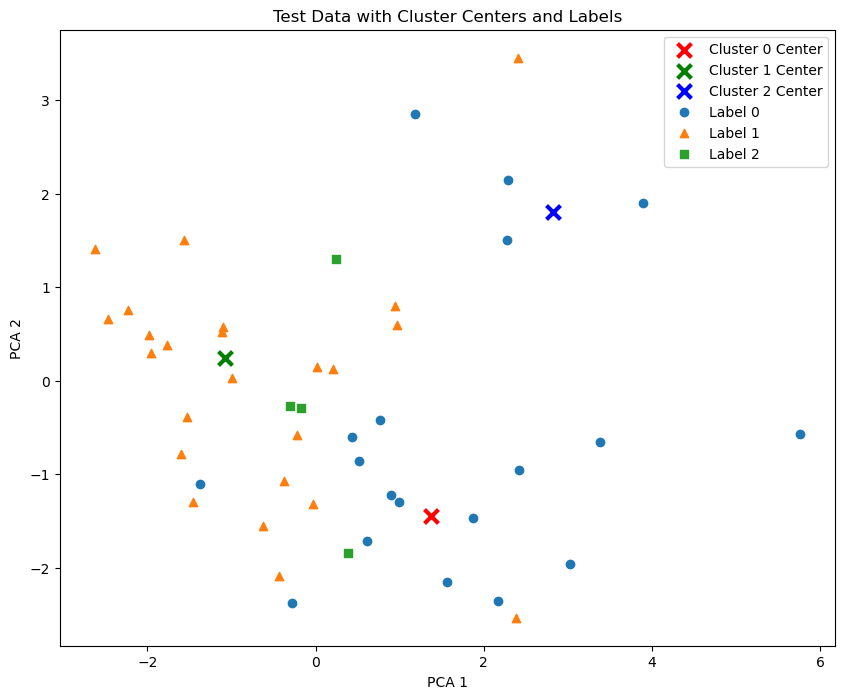

In [8]:
# Define a color for each cluster
cluster_colors = ['red', 'green', 'blue']
# Define a marker for each true label
label_markers = {0: 'o', 1: '^', 2: 's'}

plt.figure(figsize=(10, 8))

# Plot the cluster centers
centers = kmeans_best.cluster_centers_
for i, center in enumerate(centers):
    plt.scatter(center[0], center[1], c=cluster_colors[i], marker='x', s=100, linewidths=3, label=f'Cluster {i} Center')

# Plot the test data points
for label, marker in label_markers.items():
    # Select data points with the current label
    ix = y_test == label
    
    # Plot all test points with the current label
    plt.scatter(X_test_pca[ix, 0], X_test_pca[ix, 1], marker=marker, label=f"Label {label}")

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.title('Test Data with Cluster Centers and Labels')
plt.show()